In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
clean_raw=pd.read_csv("BCG_clean_data.csv")

In [3]:
df_clean=clean_raw.copy()

In [4]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14605 entries, 0 to 14604
Data columns (total 54 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      14605 non-null  int64  
 1   id                              14605 non-null  object 
 2   channel_sales                   14605 non-null  object 
 3   cons_12m                        14605 non-null  int64  
 4   cons_gas_12m                    14605 non-null  int64  
 5   cons_last_month                 14605 non-null  int64  
 6   date_activ                      14605 non-null  object 
 7   date_end                        14605 non-null  object 
 8   date_modif_prod                 14605 non-null  object 
 9   date_renewal                    14605 non-null  object 
 10  forecast_cons_12m               14605 non-null  float64
 11  forecast_cons_year              14605 non-null  int64  
 12  forecast_discount_energy        

In [5]:
df_clean.drop(columns = 'Unnamed: 0', inplace=True)

In [6]:
date_cols=['date_activ','date_end','date_modif_prod','date_renewal']
df_clean.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,mean_3m_price_off_peak_var,mean_3m_price_peak_var,mean_3m_price_mid_peak_var,mean_3m_price_off_peak_fix,mean_3m_price_peak_fix,mean_3m_price_mid_peak_fix,mean_3m_price_off_peak,mean_3m_price_peak,mean_3m_price_med_peak,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.131756,0.092638,0.036909,42.497907,12.218665,8.145777,42.629663,12.311304,8.182687,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.147600,0.000000,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.167798,0.088409,0.000000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000,0
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.148586,0.000000,0.000000,44.444710,0.000000,0.000000,44.593296,0.000000,0.000000,0
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,0.119906,0.101673,0.073719,40.728885,24.437330,16.291555,40.848791,24.539003,16.365274,0


The data consists of PowerCo's churn information which mean customer will switch to another provider or not. Note that the final column in the dataset (Churn) contains the value 0 for customer who doesn't churn, and 1 for patients who churns. This is the label that we will train our model to predict; other columns are the features we will use to predict the Churn label.

In [7]:
df_clean['date_activ']= pd.to_datetime(df_clean['date_activ'],format='%Y-%m-%d')
df_clean["date_end"] = pd.to_datetime(df_clean["date_end"], format='%Y-%m-%d')
df_clean["date_modif_prod"] = pd.to_datetime(df_clean["date_modif_prod"], format='%Y-%m-%d')
df_clean["date_renewal"] = pd.to_datetime(df_clean["date_renewal"], format='%Y-%m-%d')

In [8]:
df_clean.shape

(14605, 53)

**Feature Engineering**

Business Requirment: The difference between off-peak prices in December and January the preceding year could be a significant feature when predicting churn

In [12]:
raw_price=pd.read_csv('BCG_price_data.csv')

In [13]:
price_df = raw_price.copy()

In [14]:
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [15]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg(
    {'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}
    ).reset_index()

In [16]:
# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

In [17]:
# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1',
                                           'price_off_peak_fix': 'dec_2'}),
                 jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [18]:
monthly_price_by_id.head()

,id,price_date,price_off_peak_var,price_off_peak_fix
0,0002203ffbb812588b632b9e628cc38d,2015-01-01,0.126098,40.565969
1,0002203ffbb812588b632b9e628cc38d,2015-02-01,0.126098,40.565969
2,0002203ffbb812588b632b9e628cc38d,2015-03-01,0.128067,40.728885
3,0002203ffbb812588b632b9e628cc38d,2015-04-01,0.128067,40.728885
4,0002203ffbb812588b632b9e628cc38d,2015-05-01,0.128067,40.728885


In [19]:
jan_prices.head()

,id,price_date,price_off_peak_var,price_off_peak_fix
0,0002203ffbb812588b632b9e628cc38d,2015-01-01,0.126098,40.565969
1,0004351ebdd665e6ee664792efc4fd13,2015-01-01,0.148047,44.266931
2,0010bcc39e42b3c2131ed2ce55246e3c,2015-01-01,0.150837,44.444710
3,0010ee3855fdea87602a5b7aba8e42de,2015-01-01,0.123086,40.565969
4,00114d74e963e47177db89bc70108537,2015-01-01,0.149434,44.266931


In [20]:
df = pd.merge(df_clean, diff, on='id')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,mean_3m_price_mid_peak_var,mean_3m_price_off_peak_fix,mean_3m_price_peak_fix,mean_3m_price_mid_peak_fix,mean_3m_price_off_peak,mean_3m_price_peak,mean_3m_price_med_peak,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.036909,42.497907,12.218665,8.145777,42.629663,12.311304,8.182687,1,0.020057,3.700961
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000,0,-0.003767,0.177779
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000,0,-0.004670,0.177779
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000000,44.444710,0.000000,0.000000,44.593296,0.000000,0.000000,0,-0.004547,0.177779
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,0.073719,40.728885,24.437330,16.291555,40.848791,24.539003,16.365274,0,-0.006192,0.162916


In [21]:
raw_df=df.copy()

In the dataset, we have some datetime features:

date_activ = date of activation of the contract

date_end = registered date of the end of the contract

date_modif_prod = date of the last modification of the product

date_renewal = date of the next contract renewal From these features, we can create new columns called:

tenure: the time customer uses service of PowerCo

months_activ = Number of months active until reference date (Jan 2016)

months_to_end = Number of months of the contract left until reference date (Jan 2016)

months_modif_prod = Number of months since last modification until reference date (Jan 2016)

months_renewal = Number of months since last renewal until reference date (Jan 2016)

In [22]:
df= raw_df.copy()

In [23]:
# We no longer need the datetime columns so we can drop them

remove = ['date_activ', 'date_end', 'date_modif_prod', 'date_renewal']

df = df.drop(columns=remove)
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,...,mean_3m_price_mid_peak_var,mean_3m_price_off_peak_fix,mean_3m_price_peak_fix,mean_3m_price_mid_peak_fix,mean_3m_price_off_peak,mean_3m_price_peak,mean_3m_price_med_peak,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.00,0,0.0,1.78,0.114481,...,0.036909,42.497907,12.218665,8.145777,42.629663,12.311304,8.182687,1,0.020057,3.700961
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,189.95,0,0.0,16.27,0.145711,...,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000,0,-0.003767,0.177779
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,47.96,0,0.0,38.72,0.165794,...,0.000000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000,0,-0.004670,0.177779
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,240.04,0,0.0,19.83,0.146694,...,0.000000,44.444710,0.000000,0.000000,44.593296,0.000000,0.000000,0,-0.004547,0.177779
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,445.75,526,0.0,131.73,0.116900,...,0.073719,40.728885,24.437330,16.291555,40.848791,24.539003,16.365274,0,-0.006192,0.162916


**Transorm Categorical Variable**

We have 3 categorical variables including: has_gas, channel_sales, origin_up.

In [24]:
df['has_gas']=df['has_gas'].replace(['t','f'],[1,0])

In [25]:
df['channel_sales'].value_counts()

channel_sales
foosdfpfkusacimwkcsosbicdxkicaua    6753
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
sddiedcslfslkckwlfkdpoeeailfpeds      11
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: count, dtype: int64

In [26]:
df['origin_up'].value_counts()

origin_up
lxidpiddsbxsbosboudacockeimpuepw    7096
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: count, dtype: int64

In [27]:
df = pd.get_dummies(df, columns = ['channel_sales','origin_up'],dtype=int)
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,channel_sales_foosdfpfkusacimwkcsosbicdxkicaua,channel_sales_lmkebamcaaclubfxadlmueccxoimlema,channel_sales_sddiedcslfslkckwlfkdpoeeailfpeds,channel_sales_usilxuppasemubllopkaafesmlibmsdf,origin_up_MISSING,origin_up_ewxeelcelemmiwuafmddpobolfuxioce,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw,origin_up_usapbepcfoloekilkwsdiboslwaxobdp
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,...,1,0,0,0,0,0,0,0,1,0
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,...,0,0,0,0,0,0,1,0,0,0
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,...,1,0,0,0,0,0,1,0,0,0
3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0.0,19.83,0.146694,0.000000,...,0,1,0,0,0,0,1,0,0,0
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0.0,131.73,0.116900,0.100015,...,0,0,0,0,0,0,1,0,0,0


In [28]:
df.columns

Index(['id', 'cons_12m', 'cons_gas_12m', 'cons_last_month',
       'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
       'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'has_gas',
       'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'pow_max',
       'mean_year_price_off_peak_var', 'mean_year_price_peak_var',
       'mean_year_price_mid_peak_var', 'mean_year_price_off_peak_fix',
       'mean_year_price_peak_fix', 'mean_year_price_mid_peak_fix',
       'mean_year_price_off_peak', 'mean_year_price_peak',
       'mean_year_price_med_peak', 'mean_6m_price_off_peak_var',
       'mean_6m_price_peak_var', 'mean_6m_price_mid_peak_var',
       'mean_6m_price_off_peak_fix', 'mean_6m_price_peak_fix',
       'mean_6m_price_mid_peak_fix', 'mean_6m_price_off_peak',
       'mean_6m_price_peak', 'mean_6m_price_med_peak',
       'mea

In [29]:
#remove values with very little occurences
df = df.drop(columns=['channel_sales_sddiedcslfslkckwlfkdpoeeailfpeds',
                      'channel_sales_epumfxlbckeskwekxbiuasklxalciiuu',
                      'channel_sales_fixdbufsefwooaasfcxdxadsiekoceaa',
                     'origin_up_MISSING',
                      'origin_up_usapbepcfoloekilkwsdiboslwaxobdp',
                      'origin_up_ewxeelcelemmiwuafmddpobolfuxioce'])

In [30]:
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,channel_sales_MISSING,channel_sales_ewpakwlliwisiwduibdlfmalxowmwpci,channel_sales_foosdfpfkusacimwkcsosbicdxkicaua,channel_sales_lmkebamcaaclubfxadlmueccxoimlema,channel_sales_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,...,0.020057,3.700961,0,0,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,...,-0.003767,0.177779,1,0,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,...,-0.004670,0.177779,0,0,1,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0.0,19.83,0.146694,0.000000,...,-0.004547,0.177779,0,0,0,1,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0.0,131.73,0.116900,0.100015,...,-0.006192,0.162916,1,0,0,0,0,1,0,0


From the previous EDA we can see that some features are highly skewed, we need to transform the distribution to normal-like distribution. We will use log transfomation via Numpy by calling the log() function on the desired column. First, we will check skewed features, so that we can compare before and after transformation

**Note:**

square-root for moderate skew:

sqrt(x) for positively skewed data,
sqrt(max(x+1) - x) for negatively skewed data

log for greater skew:

log10(x) for positively skewed data,
log10(max(x+1) - x) for negatively skewed data

inverse for severe skew:

1/x for positively skewed data
1/(max(x+1) - x) for negatively skewed data

others: Cube Root Transformation, Box-Cox Transformation

Linearity and heteroscedasticity:

first try log transformation in a situation where the dependent variable starts to increase more rapidly with increasing independent variable values
If your data does the opposite – dependent variable values decrease more rapidly with increasing independent variable values – you can first consider a square transformation.

In [31]:
numeric_features = df[[
    'cons_12m',
    'cons_gas_12m',
    'cons_last_month',
    'forecast_cons_12m',
    'forecast_cons_year',
    'forecast_discount_energy',
    'forecast_meter_rent_12m',
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak',
    'forecast_price_pow_off_peak'
]]
numeric_features.describe().T

,count,mean,std,min,25%,50%,75%,max
cons_12m,14605.0,159230.267032,573483.629064,0.0,5674.000000,14116.000000,40764.000000,6.207104e+06
cons_gas_12m,14605.0,28091.082506,162978.563803,0.0,0.000000,0.000000,0.000000,4.154590e+06
cons_last_month,14605.0,16091.371448,64366.262314,0.0,0.000000,793.000000,3383.000000,7.712030e+05
forecast_cons_12m,14605.0,1868.638618,2387.651549,0.0,494.980000,1112.610000,2402.270000,8.290283e+04
forecast_cons_year,14605.0,1399.858747,3247.876793,0.0,0.000000,314.000000,1746.000000,1.753750e+05
forecast_discount_energy,14605.0,0.966450,5.108355,0.0,0.000000,0.000000,0.000000,3.000000e+01
forecast_meter_rent_12m,14605.0,63.090448,66.166636,0.0,16.180000,18.800000,131.030000,5.993100e+02
forecast_price_energy_off_peak,14605.0,0.137282,0.024623,0.0,0.116340,0.143166,0.146348,2.739630e-01
forecast_price_energy_peak,14605.0,0.050488,0.049037,0.0,0.000000,0.084138,0.098837,1.959750e-01
forecast_price_pow_off_peak,14605.0,43.130085,4.486140,0.0,40.606701,44.311378,44.311378,5.926638e+01


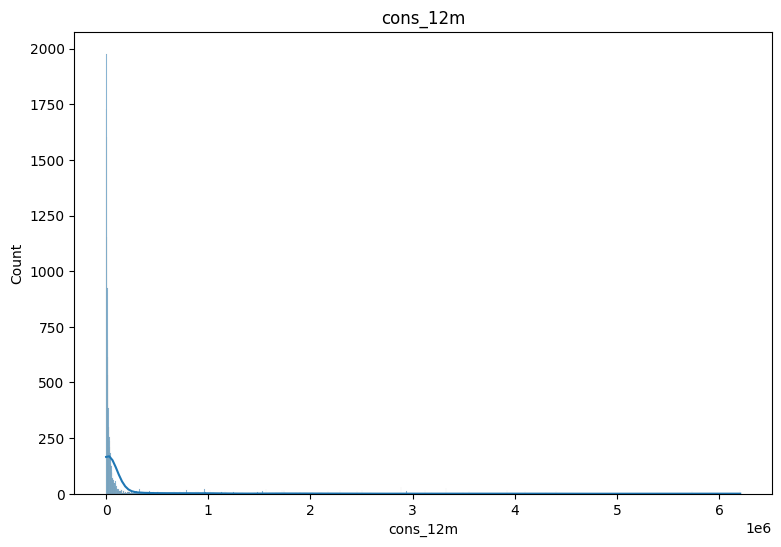

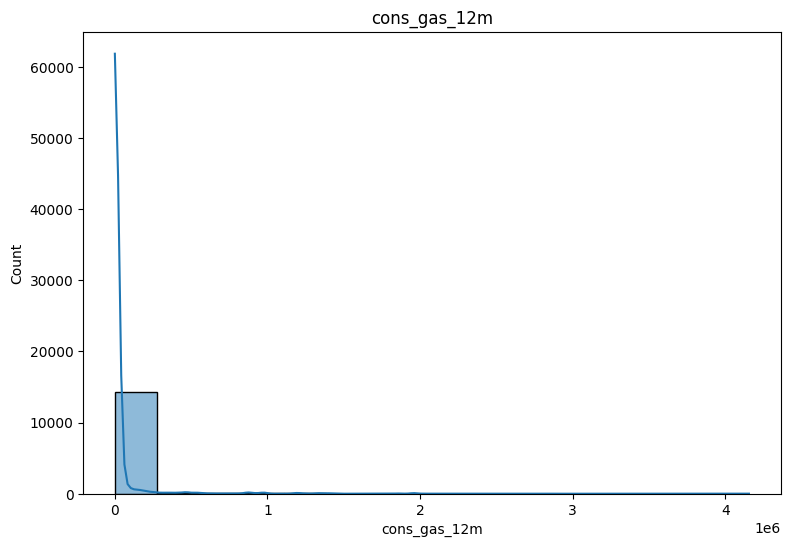

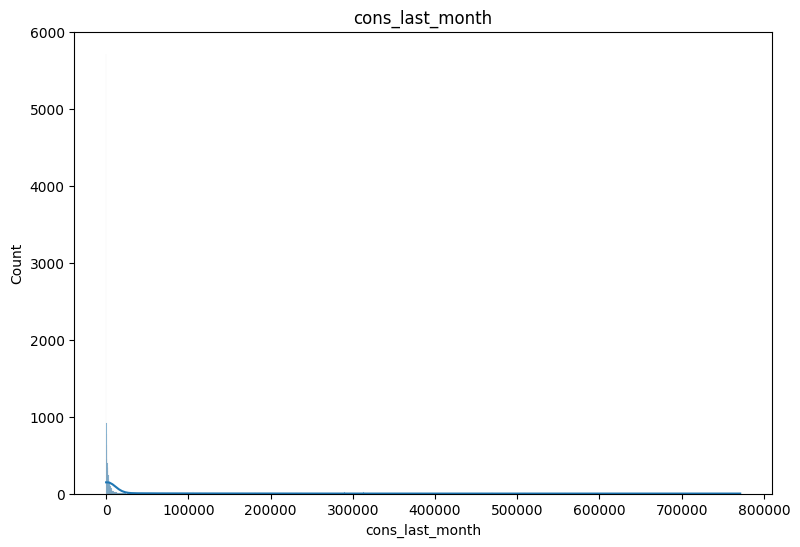

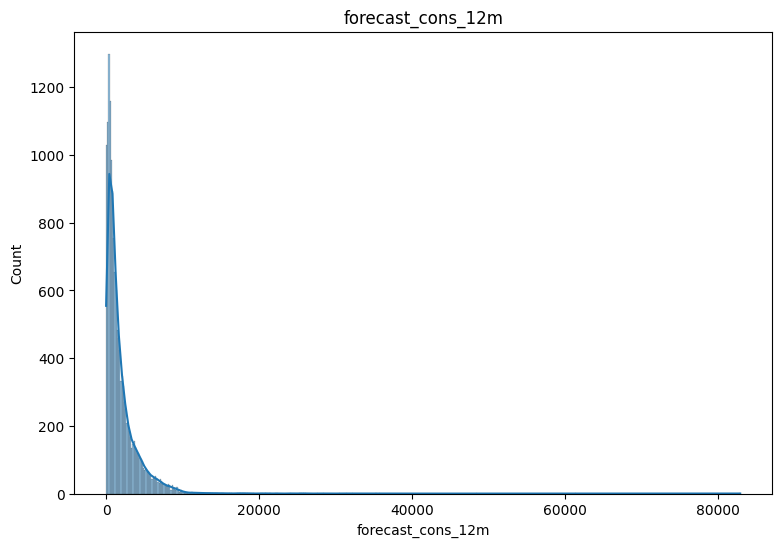

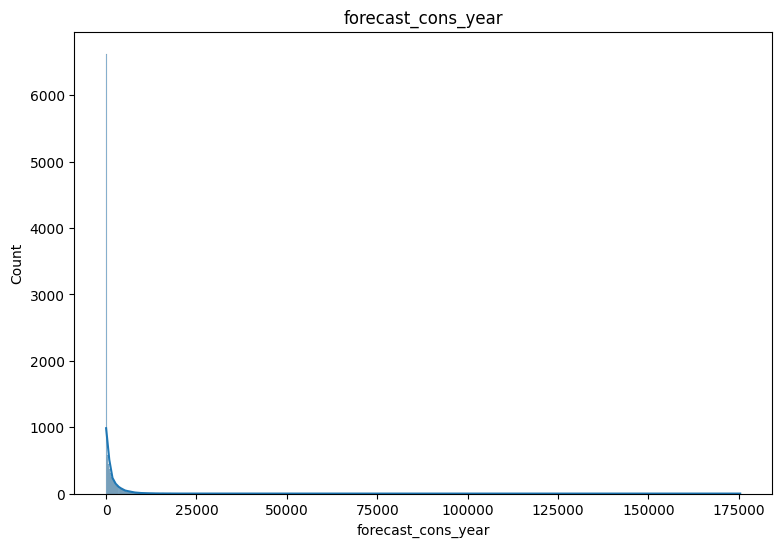

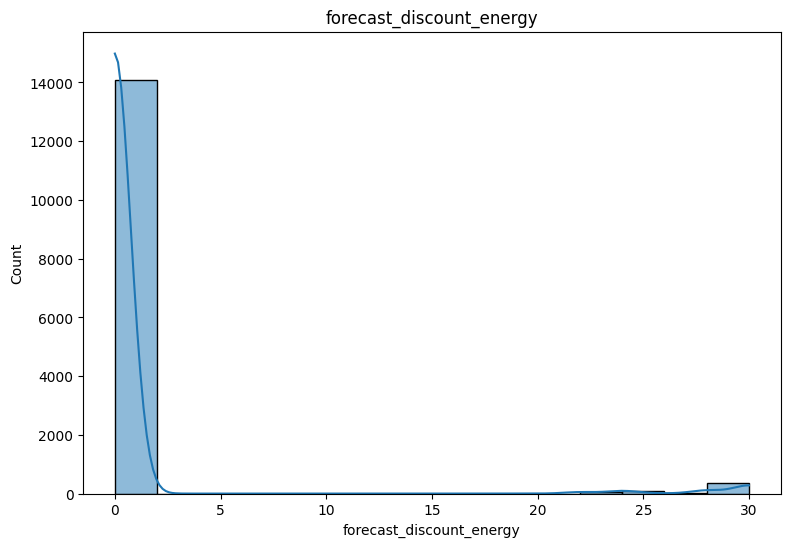

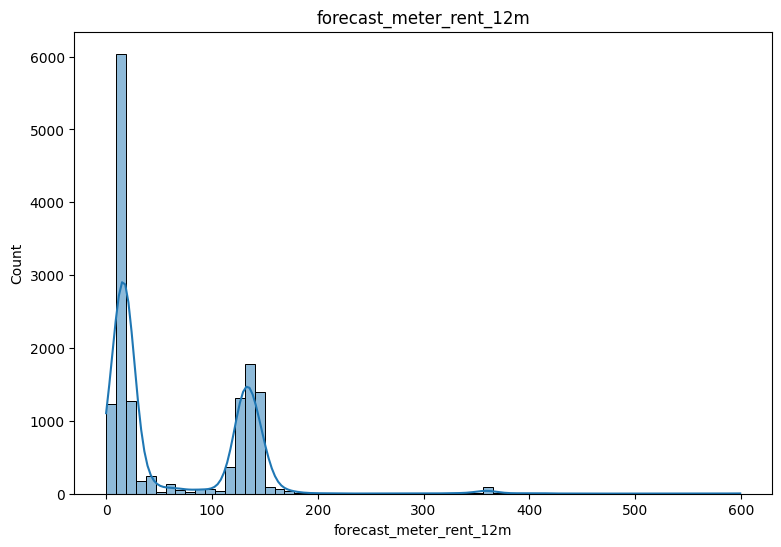

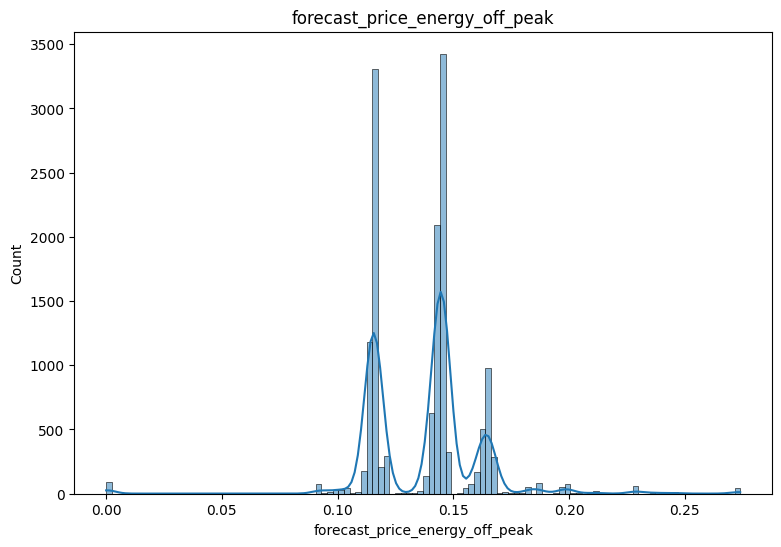

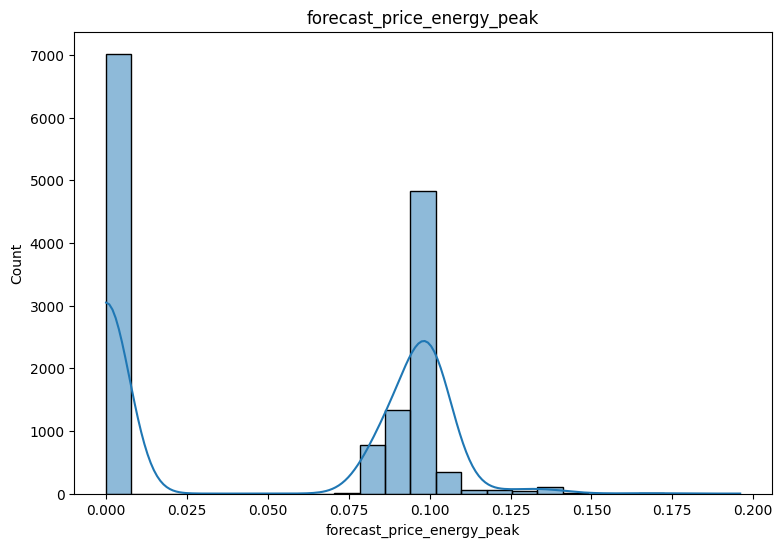

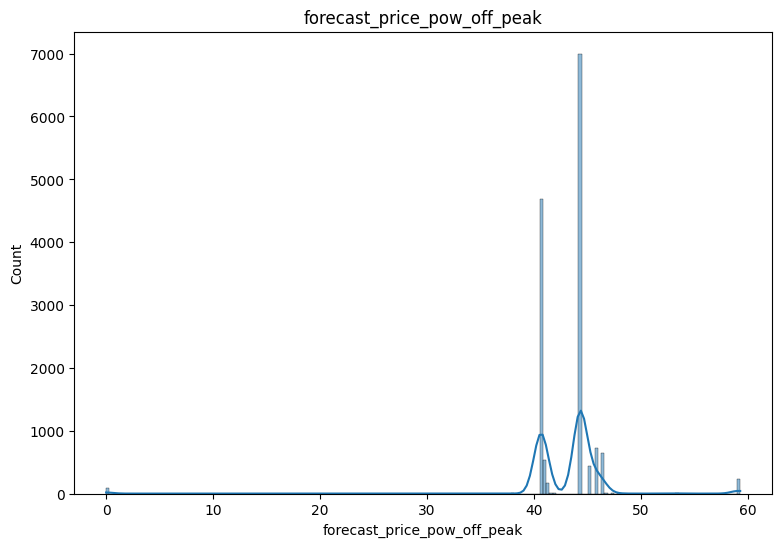

In [32]:
for col in numeric_features:
    fig = plt.figure(figsize=(9, 6))
    feature = df[col]
    sns.histplot(feature,kde=True)
    plt.title(col)
plt.show()

We can see that the most of these features is high skewed. Note that we cannot apply log to a value of 0(as per the graph), so we will add a constant of 1 to all the values.

In [42]:
for i in numeric_features:
    df[i]=df[i].apply(lambda x:np.log10(1+x))

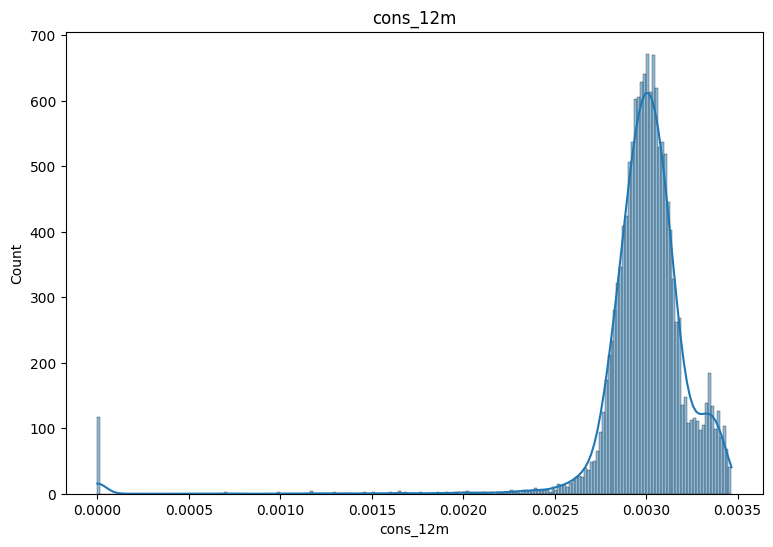

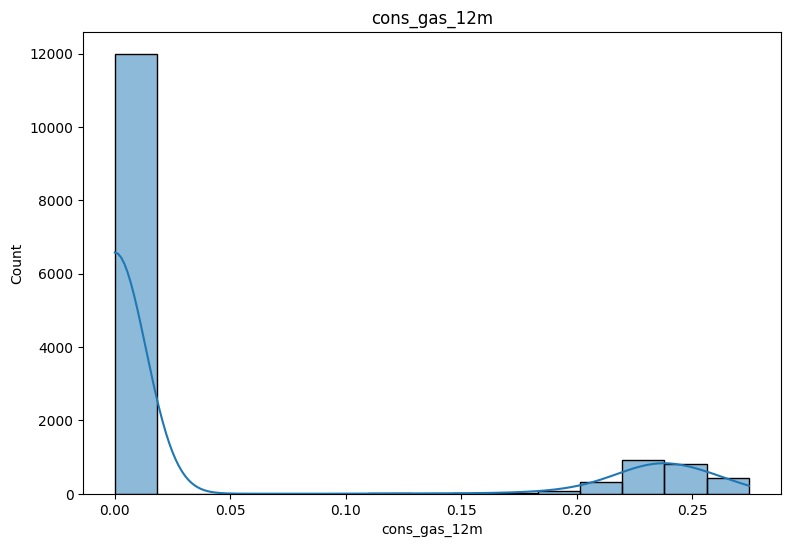

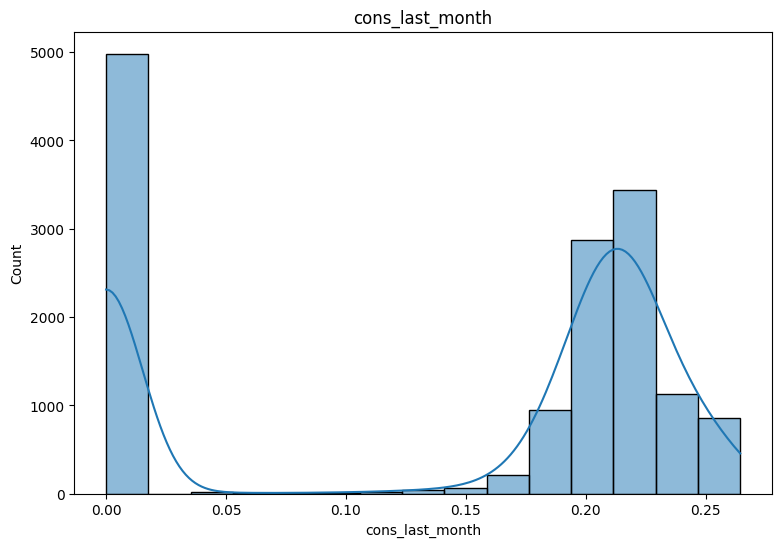

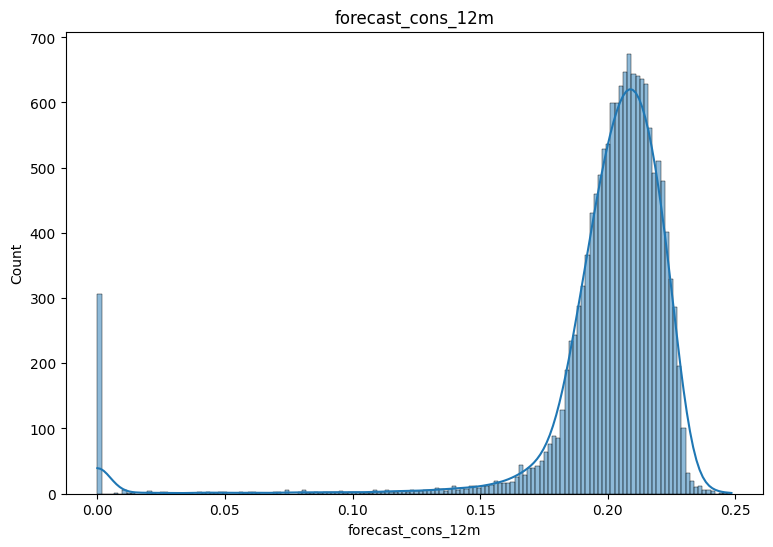

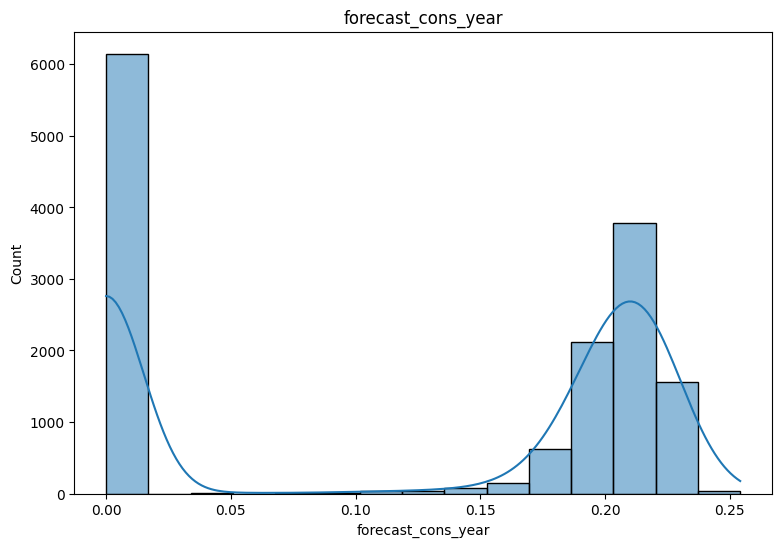

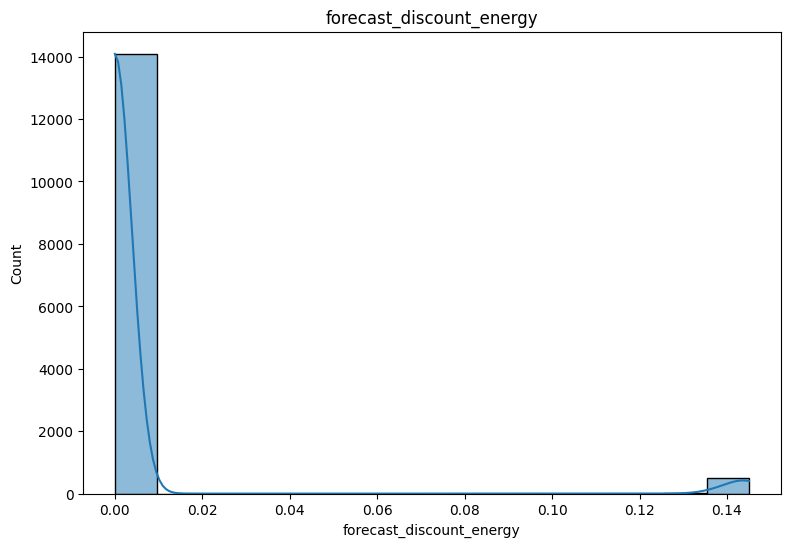

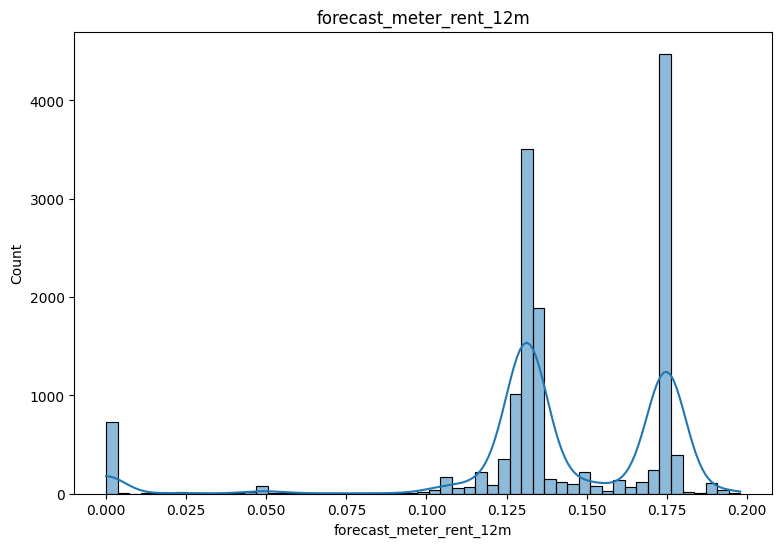

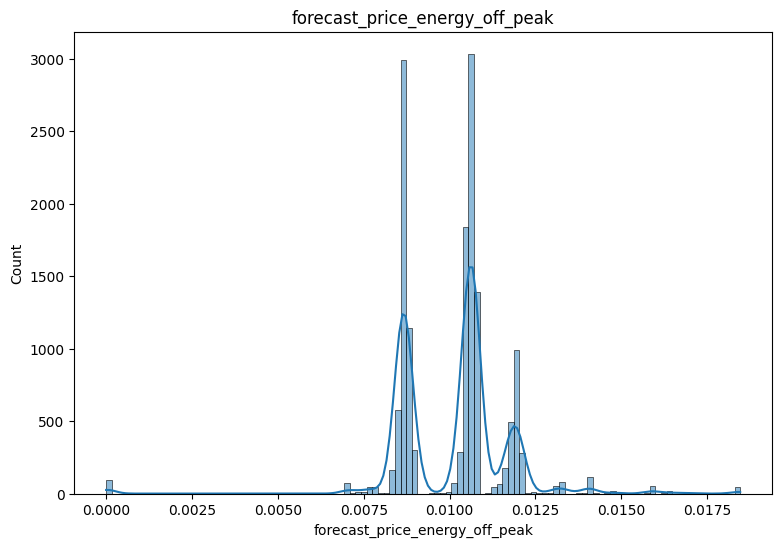

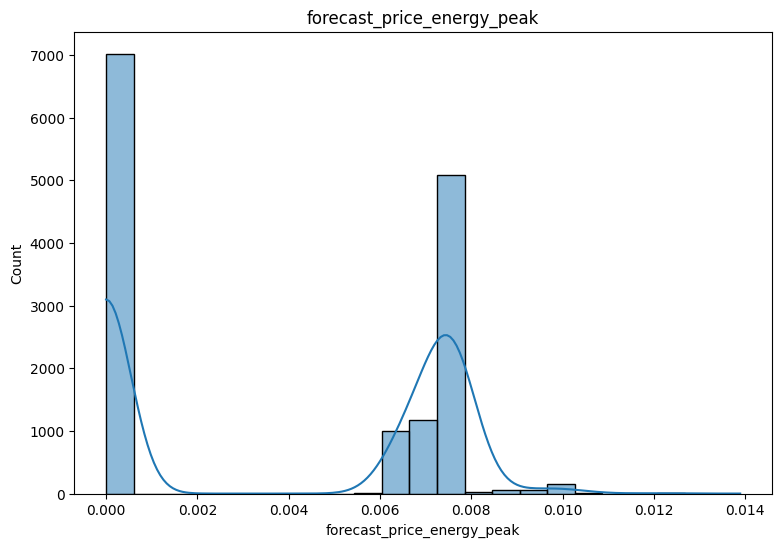

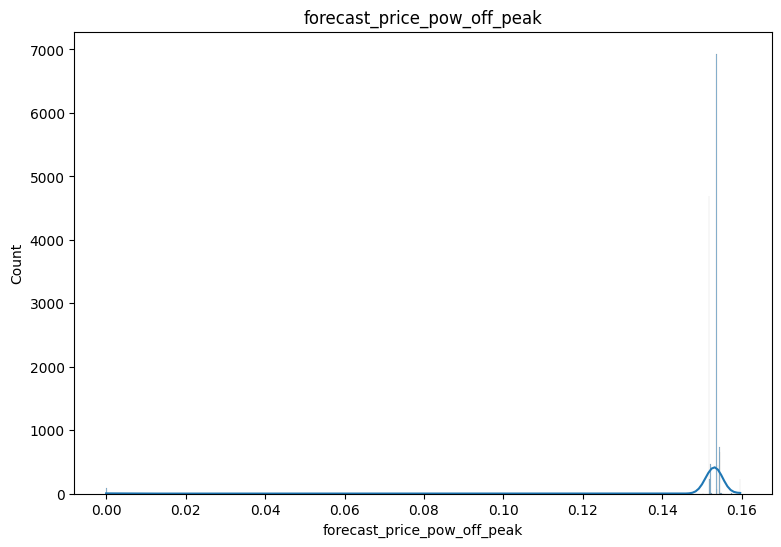

In [43]:
for col in numeric_features:
    fig = plt.figure(figsize=(9, 6))
    feature = df[col]
    sns.histplot(feature,kde=True)
    plt.title(col)
plt.show()

In [45]:
numeric_features = df[[
    'cons_12m',
    'cons_gas_12m',
    'cons_last_month',
    'forecast_cons_12m',
    'forecast_cons_year',
    'forecast_discount_energy',
    'forecast_meter_rent_12m',
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak',
    'forecast_price_pow_off_peak'
]]
numeric_features.describe().T

,count,mean,std,min,25%,50%,75%,max
cons_12m,14605.0,0.002991,0.000329,0.0,0.002913,0.003010,0.003111,0.003466
cons_gas_12m,14605.0,0.042088,0.090657,0.0,0.000000,0.000000,0.000000,0.274590
cons_last_month,14605.0,0.140979,0.103182,0.0,0.000000,0.201682,0.219072,0.264355
forecast_cons_12m,14605.0,0.199505,0.034939,0.0,0.195254,0.206044,0.215255,0.248517
forecast_cons_year,14605.0,0.118828,0.102474,0.0,0.000000,0.188607,0.211548,0.254176
forecast_discount_energy,14605.0,0.005001,0.026269,0.0,0.000000,0.000000,0.000000,0.145021
forecast_meter_rent_12m,14605.0,0.140330,0.040207,0.0,0.130103,0.133889,0.174423,0.197916
forecast_price_energy_off_peak,14605.0,0.010106,0.001654,0.0,0.008718,0.010525,0.010735,0.018461
forecast_price_energy_peak,14605.0,0.003834,0.003718,0.0,0.000000,0.006456,0.007502,0.013893
forecast_price_pow_off_peak,14605.0,0.152119,0.012312,0.0,0.151726,0.153590,0.153590,0.159584


**Correlations**

Correlation reveals the linear relationships between features. We want features to correlate with churn, as this will indicate that they are good predictors of it. However features that have a very high correlation can sometimes be suspicious. This is because 2 columns that have high correlation indicates that they may share a lot of the same information.

For features to be independent, this means that each feature must have absolutely no dependence on any other feature. If two features are highly correlated and share similar information, we can remove them.

In [74]:
history_new=df[[
   'mean_6m_price_off_peak_var','mean_6m_price_peak_var','mean_6m_price_mid_peak_var','mean_6m_price_off_peak_fix',
   'mean_6m_price_peak_fix','mean_6m_price_mid_peak_fix','mean_6m_price_off_peak','mean_6m_price_peak',
   'mean_6m_price_med_peak','mean_3m_price_off_peak_var','mean_3m_price_peak_var','mean_3m_price_mid_peak_var',
   'mean_3m_price_off_peak_fix','mean_3m_price_peak_fix','mean_3m_price_mid_peak_fix','mean_3m_price_off_peak',
   'mean_3m_price_peak','mean_3m_price_med_peak','mean_year_price_off_peak_var','mean_year_price_peak_var',
   'mean_year_price_mid_peak_var','mean_year_price_off_peak_fix','mean_year_price_peak_fix',
   'mean_year_price_mid_peak_fix','mean_year_price_off_peak','mean_year_price_peak','mean_year_price_med_peak'
]]
history_df = pd.DataFrame(history_new)

In [75]:
hist_corr=history_df.corr()

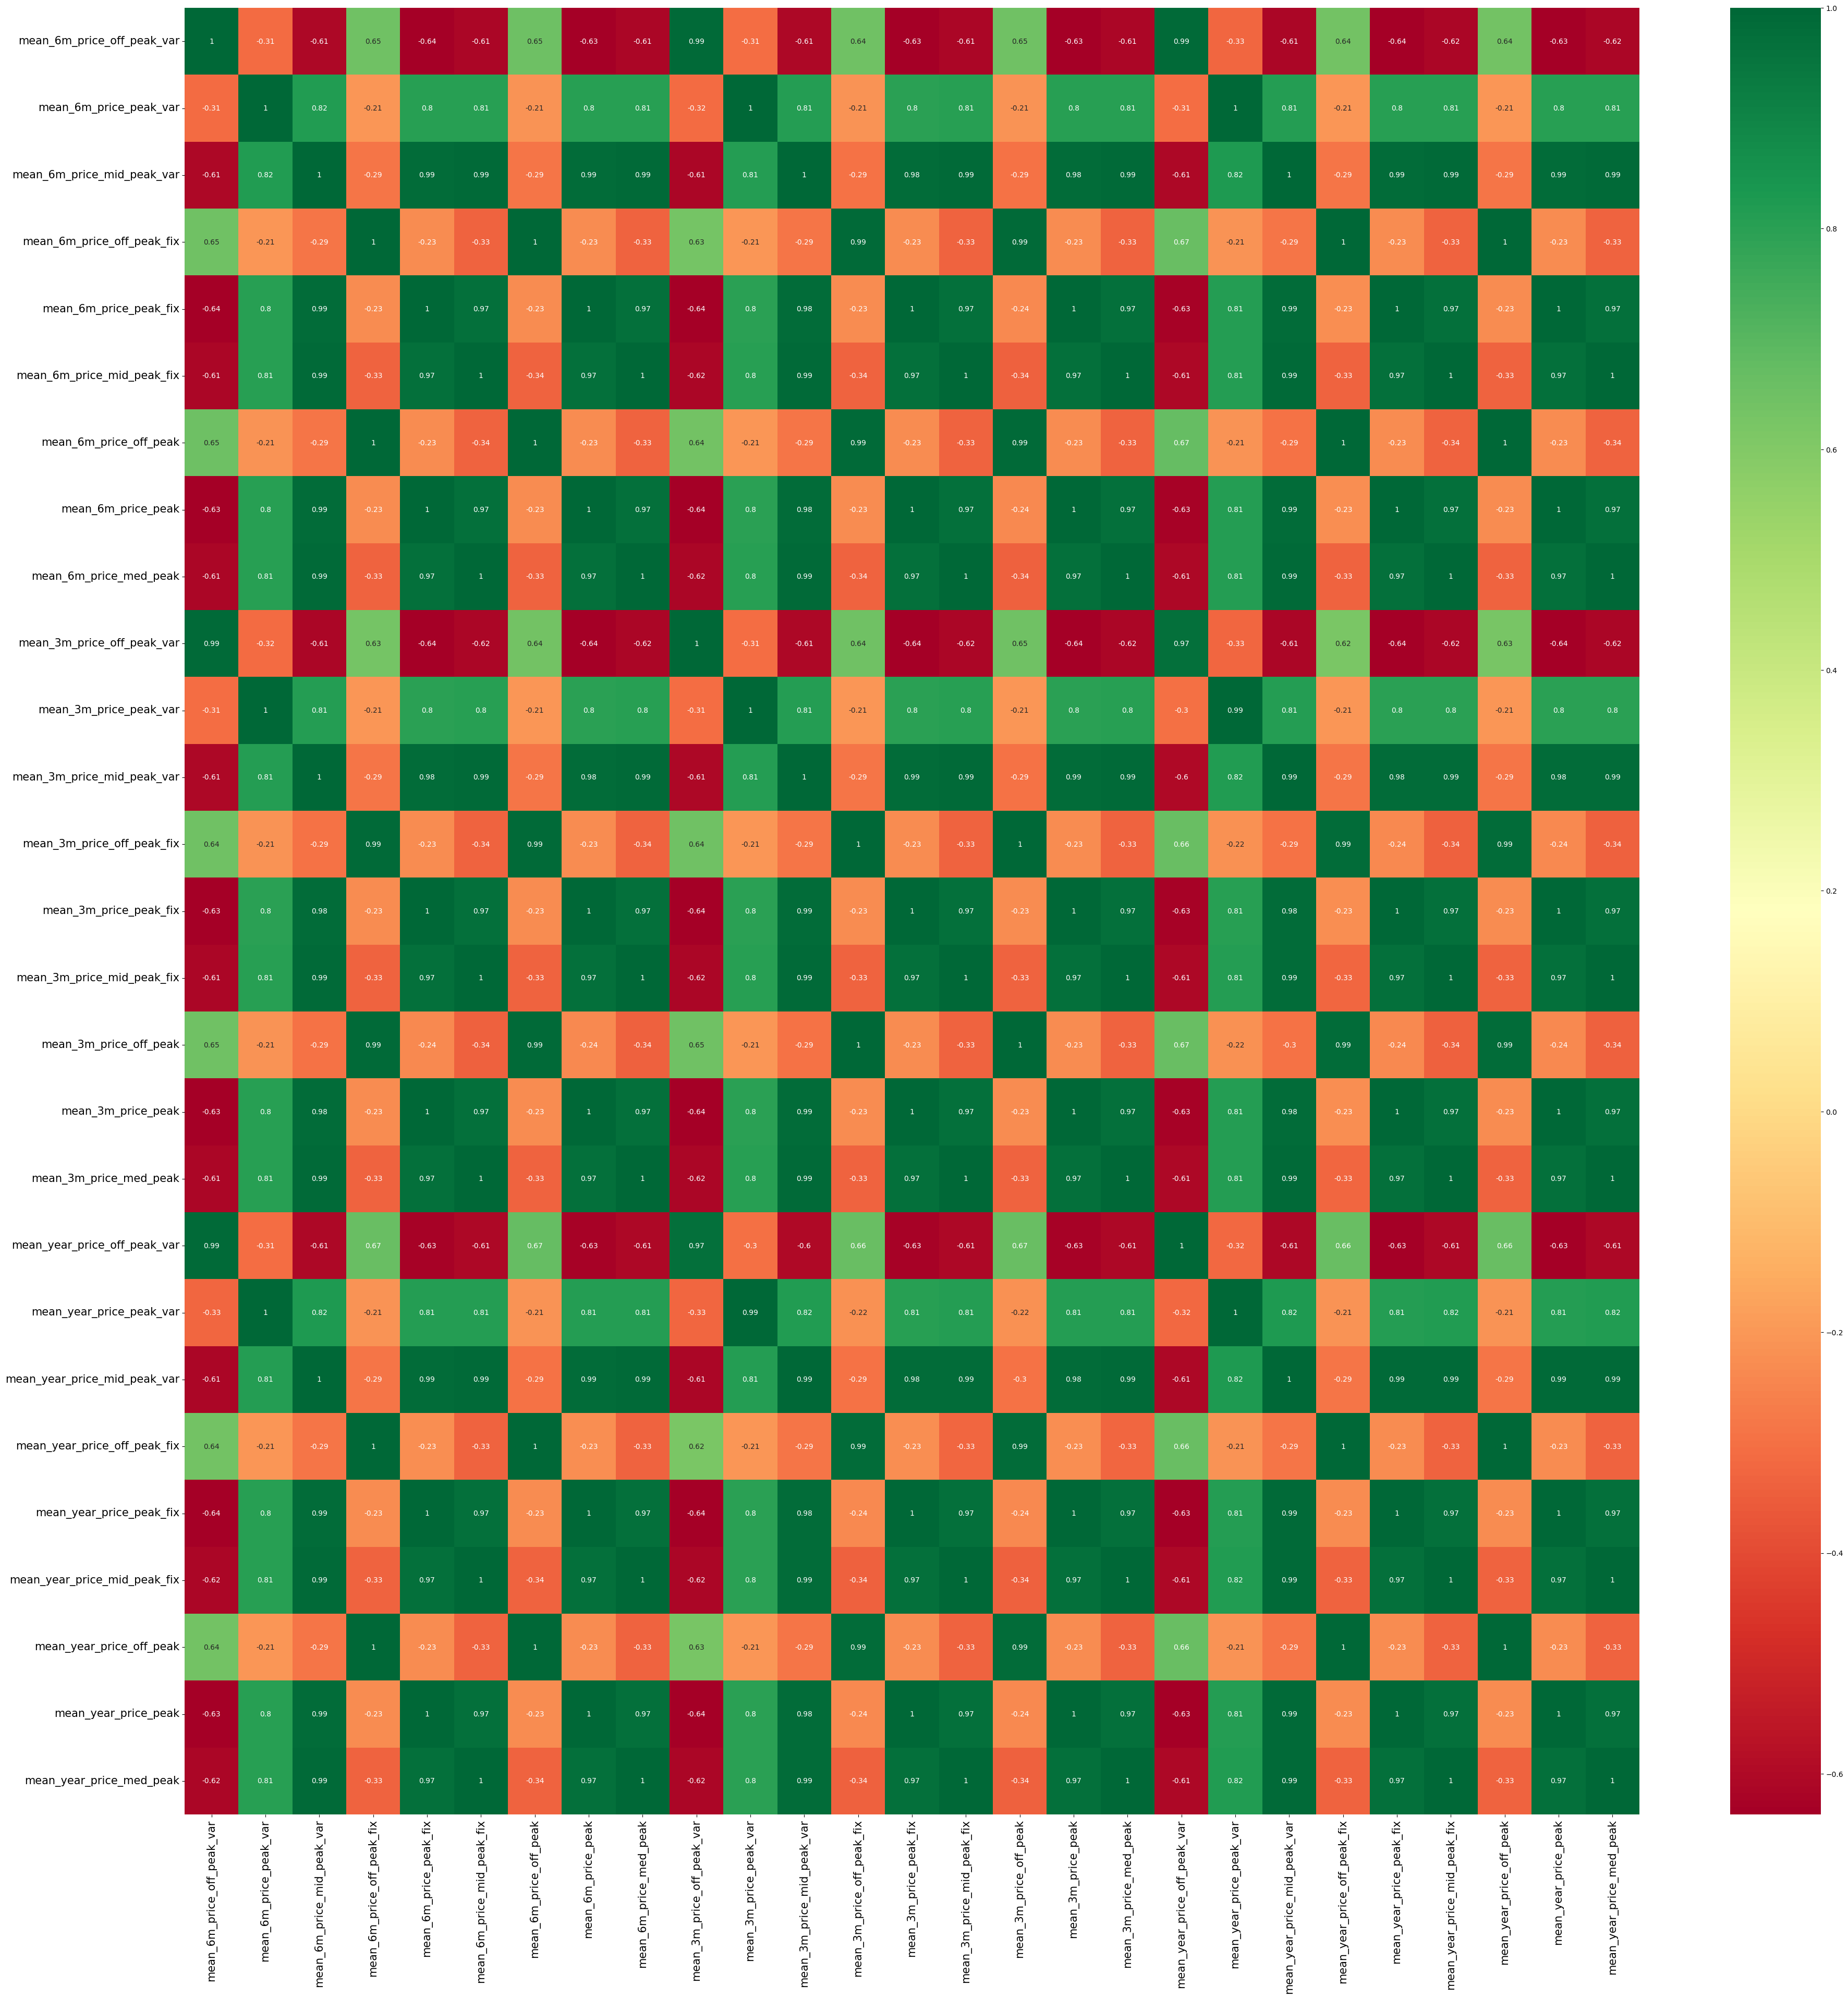

In [76]:
# Plot correlation
plt.figure(figsize=(45, 45))
sns.heatmap(
    hist_corr,
    xticklabels=hist_corr.columns.values,
    yticklabels=hist_corr.columns.values,
    annot=True,
    cmap='RdYlGn'
 )
# Axis ticks size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

the above features are highly correlated with each other

In [77]:
drop_features=['id','mean_6m_price_off_peak_var','mean_6m_price_peak_var',
               'mean_6m_price_mid_peak_var','mean_6m_price_off_peak_fix',
   'mean_6m_price_peak_fix','mean_6m_price_mid_peak_fix','mean_6m_price_off_peak','mean_6m_price_peak',
   'mean_6m_price_med_peak','mean_3m_price_off_peak_var','mean_3m_price_peak_var','mean_3m_price_mid_peak_var',
   'mean_3m_price_off_peak_fix','mean_3m_price_peak_fix','mean_3m_price_mid_peak_fix','mean_3m_price_off_peak',
   'mean_3m_price_peak','mean_3m_price_med_peak','mean_year_price_off_peak_var','mean_year_price_peak_var',
   'mean_year_price_mid_peak_var','mean_year_price_off_peak_fix','mean_year_price_peak_fix',
   'mean_year_price_mid_peak_fix','mean_year_price_off_peak','mean_year_price_peak','mean_year_price_med_peak']

df_corr=df.drop(drop_features,axis=1)

In [78]:
correlation = df_corr.corr()

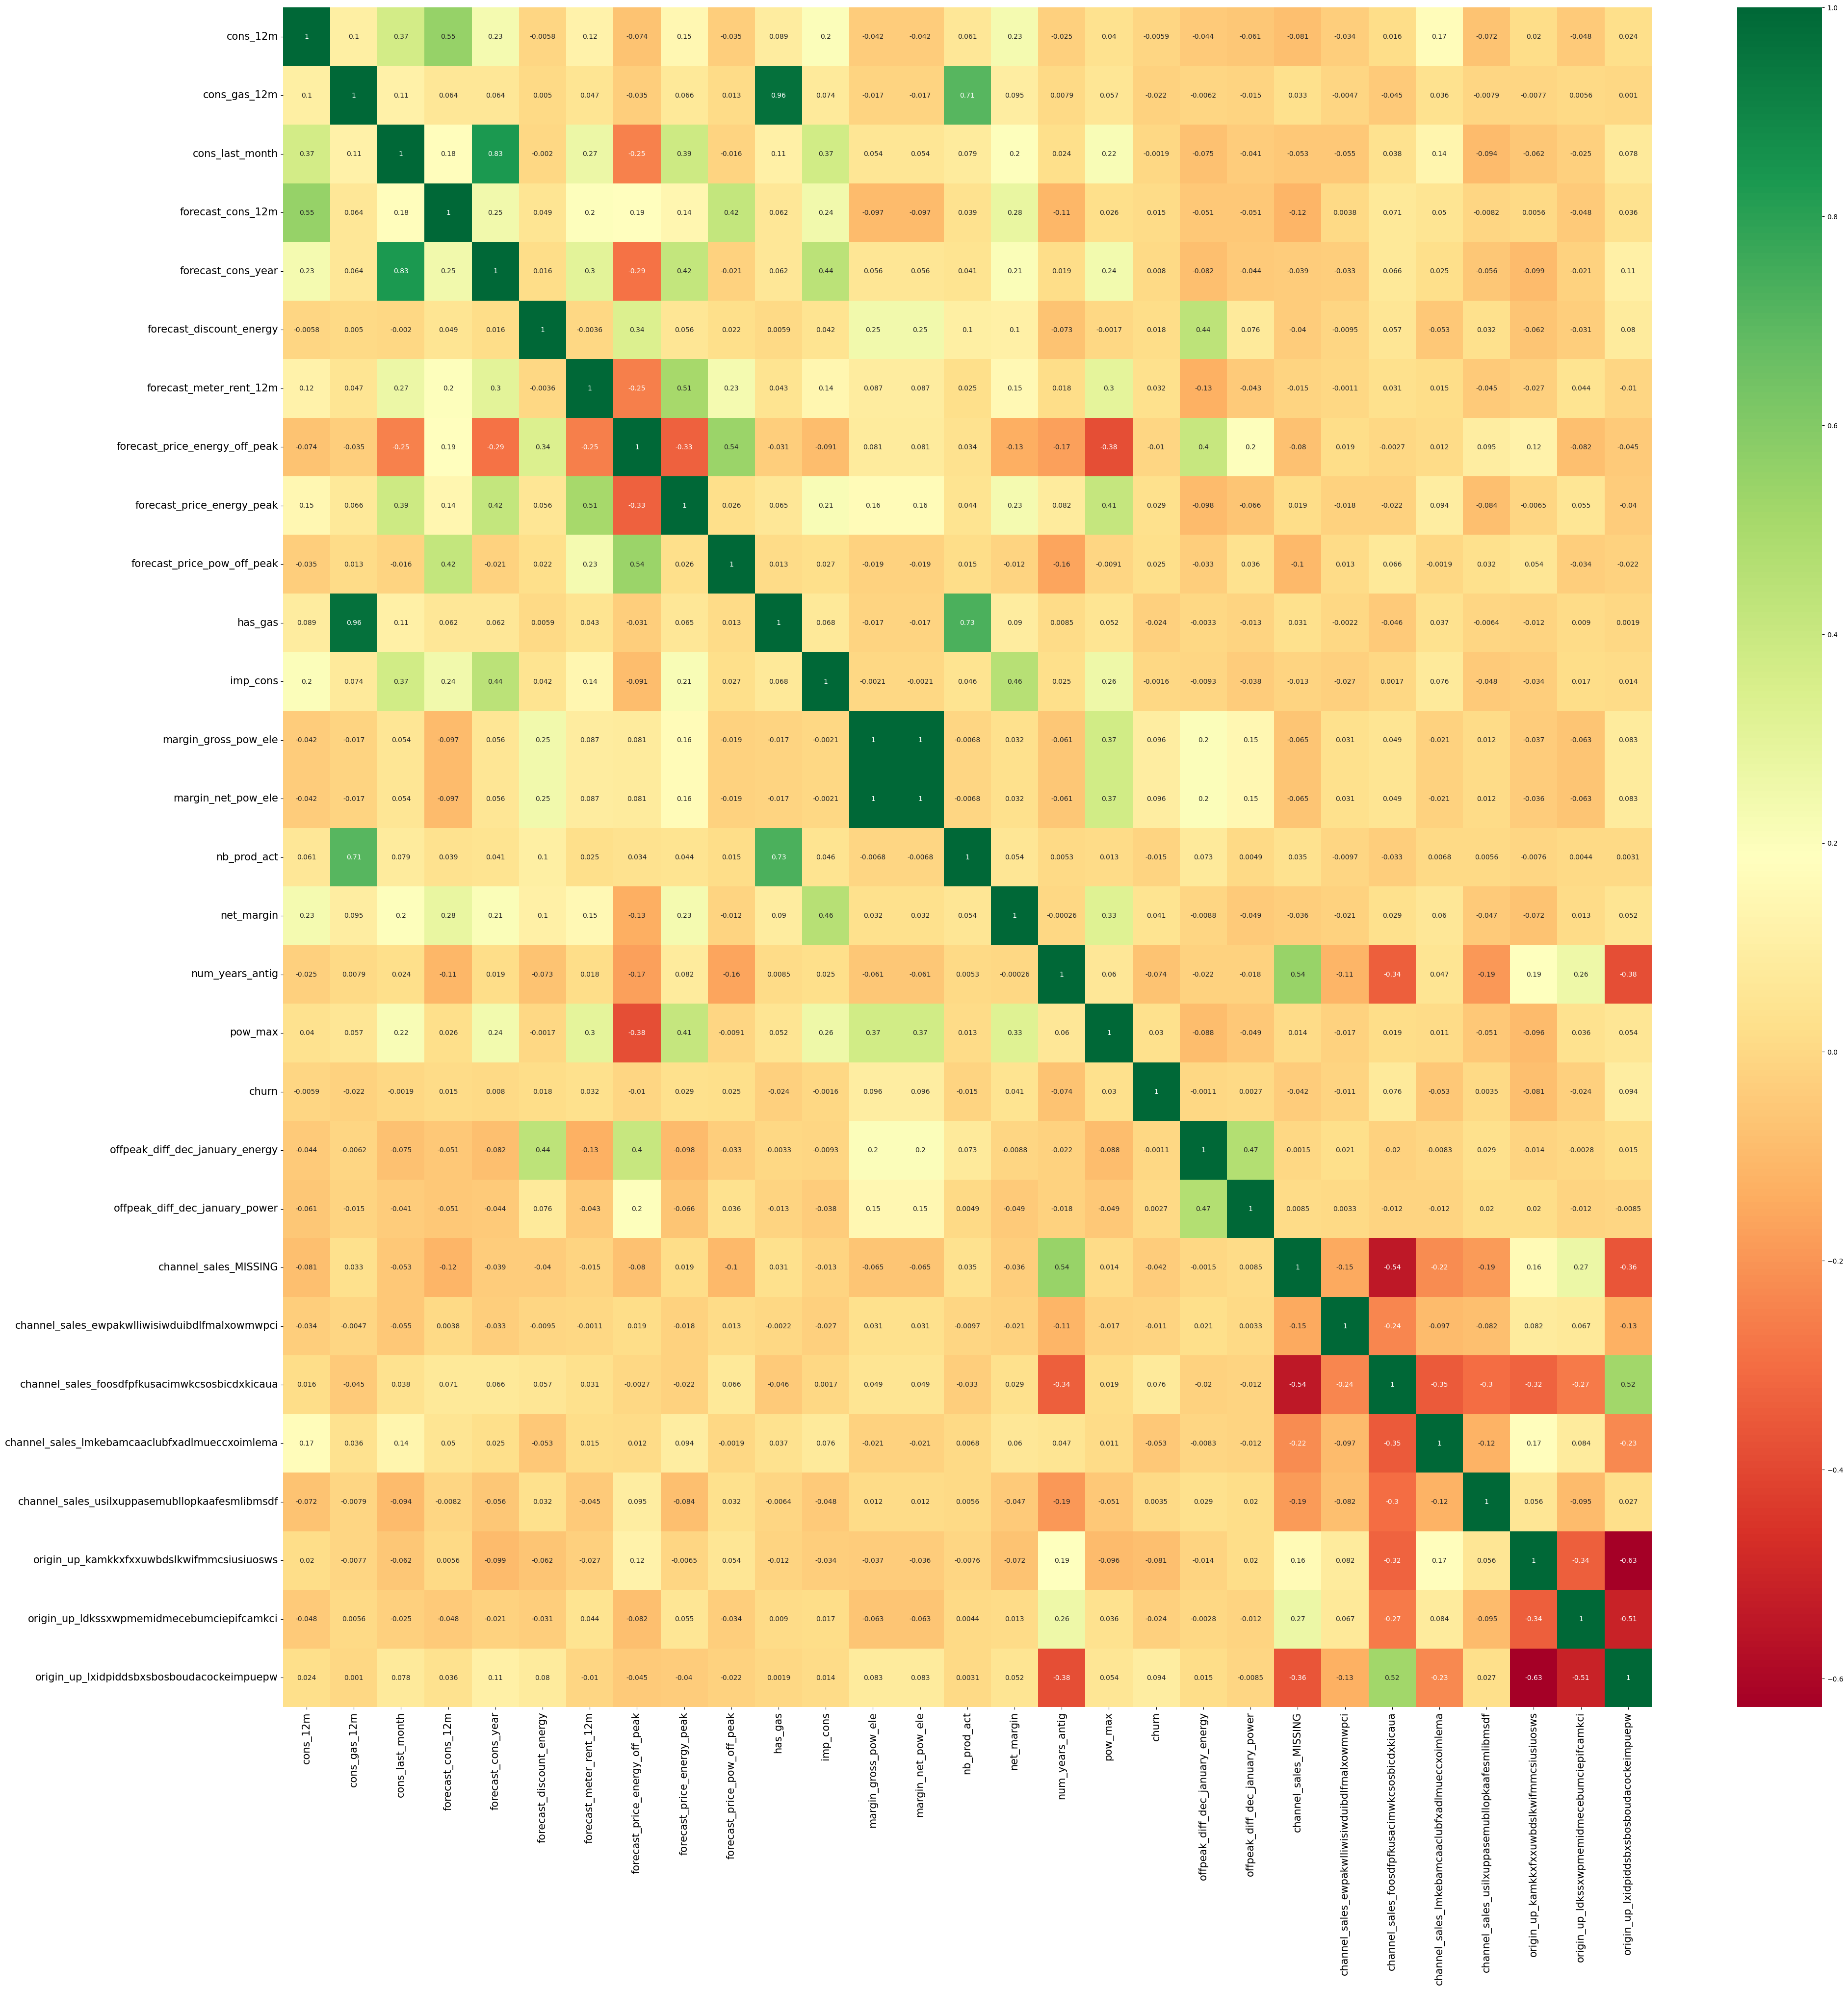

In [79]:
# Plot correlation
plt.figure(figsize=(45, 45))
sns.heatmap(
    correlation,
    xticklabels=correlation.columns.values,
    yticklabels=correlation.columns.values,
    annot=True,
    cmap='RdYlGn'
 )
# Axis ticks size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

####**Removing outliers**

In [80]:
df_outlier=df.copy()

In [117]:
def remove_outliers(df,col):
    df.loc[df[col]<0,col]=df[col].mean()
    q1=df[col].quantile(.25)
    q3=df[col].quantile(.75)
    iqr=q3-q1
    upper_bound=q3+(iqr*1.5)
    lower_bound=q1-(iqr*1.5)
    df=df[(lower_bound<df[col])|(df[col]<upper_bound)]

In [118]:
remove_outliers(df_outlier,'imp_cons')

In [119]:
df_outlier.describe().T

,count,mean,std,min,25%,50%,75%,max
cons_12m,14605.0,0.002991,0.000329,0.000000,0.002913,0.003010,0.003111,0.003466
cons_gas_12m,14605.0,0.042088,0.090657,0.000000,0.000000,0.000000,0.000000,0.274590
cons_last_month,14605.0,0.140979,0.103182,0.000000,0.000000,0.201682,0.219072,0.264355
forecast_cons_12m,14605.0,0.199505,0.034939,0.000000,0.195254,0.206044,0.215255,0.248517
forecast_cons_year,14605.0,0.118828,0.102474,0.000000,0.000000,0.188607,0.211548,0.254176
forecast_discount_energy,14605.0,0.005001,0.026269,0.000000,0.000000,0.000000,0.000000,0.145021
forecast_meter_rent_12m,14605.0,0.140330,0.040207,0.000000,0.130103,0.133889,0.174423,0.197916
forecast_price_energy_off_peak,14605.0,0.010106,0.001654,0.000000,0.008718,0.010525,0.010735,0.018461
forecast_price_energy_peak,14605.0,0.003834,0.003718,0.000000,0.000000,0.006456,0.007502,0.013893
forecast_price_pow_off_peak,14605.0,0.152119,0.012312,0.000000,0.151726,0.153590,0.153590,0.159584
